In [1]:
import pandas as pd
import pylab
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

df = pd.read_csv('./data/card_transdata.csv')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Throughout the post model evaulation, it will use decision tree model 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#separate "fraud" column (class label)
X = df.drop("fraud", axis=1)
y = df["fraud"]

#split the data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)

#train DecisionTreeClassifier model
dt_model = DecisionTreeClassifier().fit(X_train, y_train)

### Generate Profile Report

In [3]:
from ydata_profiling import ProfileReport

#it uses a pearson correlation
profile = ProfileReport(
        df, 
        title="Data Profiling Report", 
        explorative=True, 
        correlations = {
        "pearson": {"calculate": True},
    },)

profile.to_file("card_transdata_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### check data leakage by checking a single or combination of two features has only 1 class lebel value of not.

In [4]:
#categorical features
categorical = ['repeat_retailer', 'used_chip', 'used_pin_number', 'used_pin_number']
numeric = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

print("single feature")
for col in numeric:
    bins = pd.cut(df[col], bins=10)
    nunique_per_bin = df.groupby(bins)['fraud'].nunique()
    print(col, nunique_per_bin)

#check any feature contains only 1 class label for (fruad=0 or fruad=1) 
for col in categorical:
    print(col, df.groupby(col)['fraud'].nunique())

print("2 features")
#check any combination of 2 features contains only 1 class label for (fruad=0 or fruad=1) 
for col1 in categorical:
    for col2 in categorical:
        # Make a group by both
        print(df.groupby([col1, col2])['fraud'].nunique())

single feature
distance_from_home distance_from_home
(-10.628, 1063.277]      2
(1063.277, 2126.549]     2
(2126.549, 3189.821]     2
(3189.821, 4253.092]     2
(4253.092, 5316.364]     2
(5316.364, 6379.636]     1
(6379.636, 7442.908]     0
(7442.908, 8506.18]      0
(8506.18, 9569.452]      1
(9569.452, 10632.724]    1
Name: fraud, dtype: int64
distance_from_last_transaction distance_from_last_transaction
(-11.851, 1185.111]       2
(1185.111, 2370.221]      2
(2370.221, 3555.331]      1
(3555.331, 4740.442]      0
(4740.442, 5925.552]      1
(5925.552, 7110.663]      0
(7110.663, 8295.773]      0
(8295.773, 9480.884]      0
(9480.884, 10665.994]     0
(10665.994, 11851.105]    1
Name: fraud, dtype: int64
ratio_to_median_purchase_price ratio_to_median_purchase_price
(-0.263, 26.784]      2
(26.784, 53.564]      2
(53.564, 80.344]      2
(80.344, 107.124]     2
(107.124, 133.904]    1
(133.904, 160.684]    1
(160.684, 187.463]    1
(187.463, 214.243]    0
(214.243, 241.023]    0
(241.

### examine learning curve to see existence of overfitting

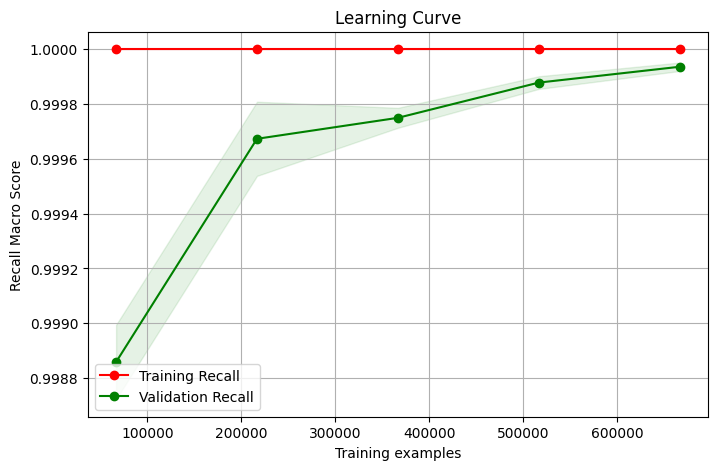

In [5]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    dt_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3,
    scoring='recall_macro',
    n_jobs=-1
)

# Calculate means and stds
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Recall')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Recall')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='g')
plt.xlabel("Training examples")
plt.ylabel("Recall Macro Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

### decision tree visualization

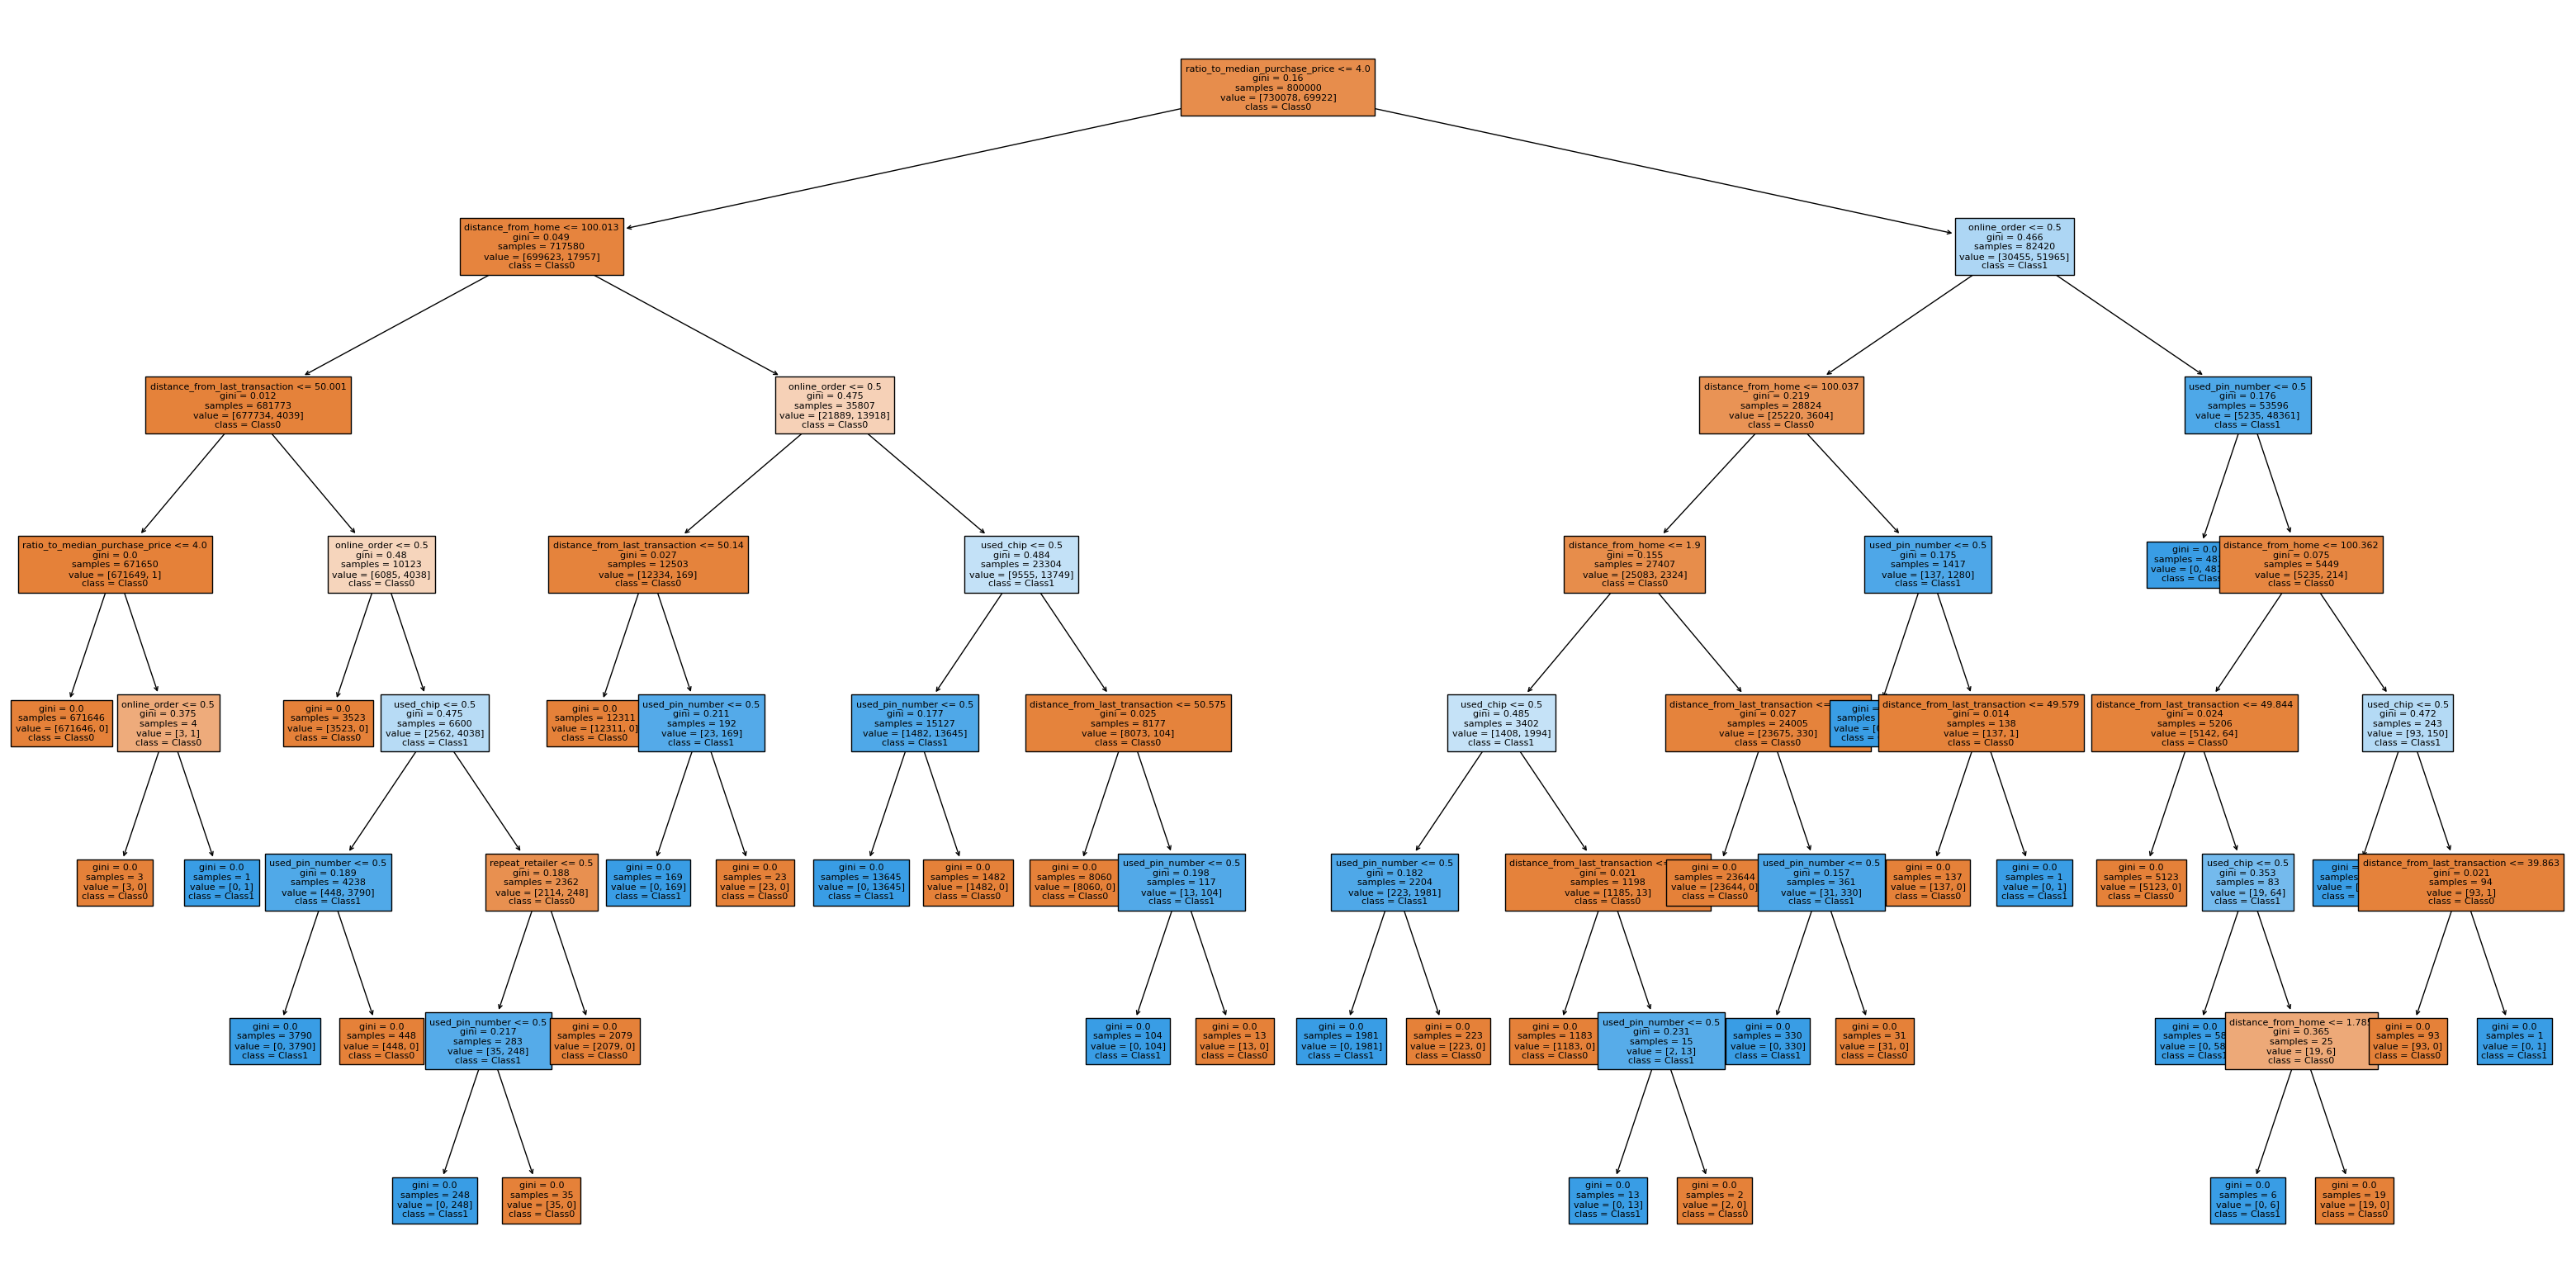

In [6]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

plt.figure(figsize=(40,20))
plot_tree(dt_model, feature_names=df.columns[:-1], class_names=['Class0','Class1'], filled=True, fontsize=8)
plt.show()

### The ablation study

In [7]:
from sklearn.model_selection import cross_val_score

features = X.columns
results = {}

for feature in features:
    # Drop the feature
    X_ablate = X.drop(feature, axis=1)    
    scores = cross_val_score(dt_model, X_ablate, y, cv=3, scoring='recall_macro', n_jobs=-1)
    results[feature] = np.mean(scores)

print("Ablation study results:")
for k, v in results.items():
    print(f"{k}: recall dropped to {v:.3f}")

Ablation study results:
distance_from_home: recall dropped to 0.888
distance_from_last_transaction: recall dropped to 0.963
ratio_to_median_purchase_price: recall dropped to 0.650
repeat_retailer: recall dropped to 1.000
used_chip: recall dropped to 0.946
used_pin_number: recall dropped to 0.942
online_order: recall dropped to 0.834


### Permutation Feature Importance

In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(dt_model, X_test, y_test, n_repeats=10, random_state=42, scoring='recall_macro')

print("Permutation Feature Importance results:")
importances = result.importances_mean
for i, col in enumerate(X_test.columns):
    print(f"Dropping {col}: {importances[i]:.3f}")

Permutation Feature Importance results:
Dropping distance_from_home: 0.124
Dropping distance_from_last_transaction: 0.037
Dropping ratio_to_median_purchase_price: 0.350
Dropping repeat_retailer: 0.002
Dropping used_chip: 0.051
Dropping used_pin_number: 0.052
Dropping online_order: 0.162


### add noise to numerical features

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


def add_noise(X, feature, noise_level=0.1):
    # Make a copy of X
    X_noisy = X.copy()
    # Assume you want to add noise to 'ratio_to_median_purchase_price' which has a high correlation to 
    X_noisy[feature] += np.random.normal(0, noise_level, size=X.shape[0])
    return X_noisy

numeric_feature = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

for feature in numeric_feature:
    noise_transformer = FunctionTransformer(add_noise, kw_args={'feature': feature, 'noise_level': 0.2})
    pipeline = make_pipeline(
        noise_transformer,
        dt_model
    )
    scores = cross_val_score(pipeline, X, y, cv=3, scoring='recall_macro', n_jobs=-1)
    print(f"recall after adding noise to '{feature}': {np.mean(scores):.3f}")

recall after adding noise to 'distance_from_home': 1.000
recall after adding noise to 'distance_from_last_transaction': 1.000
recall after adding noise to 'ratio_to_median_purchase_price': 0.982
